In [1]:
########### LIBRARIES ##########
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%pylab inline

rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8, 6]

from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler

import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = False
save = False

seed = 100
test_seed = 15

### Generate training data
For 200 initial conditions and 3 values for the $\rho$ coefficient we generate solution snapshots by integrating Lorenz system up to time $T = 8$

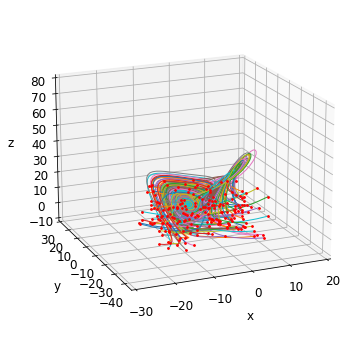

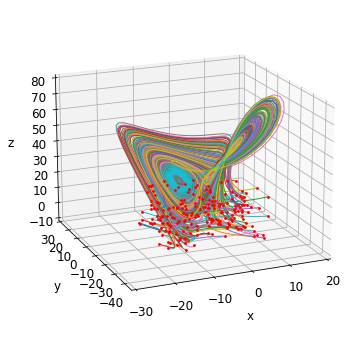

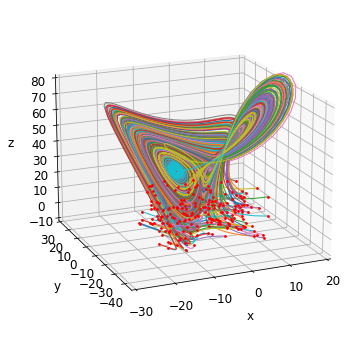

In [3]:
## Simulate the Lorenz System
dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
n_ic = 200
beta = 8/3
sigma = 10
rhos = [10, 28, 35]
n_rho = len(rhos)

nn_input = np.zeros((n_ic*(len(t)-1)*n_rho,4))
nn_output = np.zeros((n_ic*(len(t)-1)*n_rho,3))

x_t = np.zeros((n_ic, len(t)*n_rho, 3))

def lorenz_deriv(x_y_z, t0, rho, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(seed)
x0 = -15 + 30 * np.random.random((n_ic, 3))

for i, rho in enumerate(rhos):
    
    nn_input_temp = np.zeros((n_ic*(len(t)-1),3))
    nn_output_temp = np.zeros_like(nn_input_temp)

    x_t = np.asarray([integrate.odeint(lambda x,t: lorenz_deriv(x, t, rho = rho), x0_j, t)
                      for x0_j in x0])

    fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
    
    for j in range(n_ic):
        nn_input_temp[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
        nn_output_temp[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
        x, y, z = x_t[j,:,:].T
        ax.plot(x, y, z,linewidth=1)
        ax.set_xlim((-30,20))
        ax.set_ylim((-45,30))
        ax.set_zlim((-10,80))
        ax.set_xlabel('x', labelpad = 10)
        ax.set_ylabel('y', labelpad = 10)
        ax.set_zlabel('z', labelpad = 10)
        ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r', s=3)

    ax.view_init(18, -113)
    plt.savefig('./images/L_' + str(rho) + '.pdf',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    rho_input = np.ones(shape = (nn_input_temp.shape[0],1)) * rho
    nn_input_rho = np.concatenate((nn_input_temp, rho_input), axis = 1)
    
    nn_input[i*(len(t)-1)*n_ic : (i+1)*(len(t)-1)*n_ic,:] = nn_input_rho
    nn_output[i*(len(t)-1)*n_ic : (i+1)*(len(t)-1)*n_ic,:] = nn_output_temp

### Builid and train the NN model

In [4]:
# Set seed for reproducibility
np.random.seed(seed)
x_train, x_valid, y_train, y_valid = train_test_split(nn_input, nn_output, test_size = 0.1)

# Build model
nn_model = keras.models.Sequential()
nn_model.add(layers.Dense(64, input_dim=4, activation='tanh')) #32
nn_model.add(layers.Dense(64, activation='tanh'))
nn_model.add(layers.Dense(3, activation='linear'))

# Compile model
opt = keras.optimizers.Adam(learning_rate=1e-3)
nn_model.compile(loss='mse', optimizer=opt)

# Fit!
if train:
    tf.random.set_seed(seed)
    batch_size=150
    History = nn_model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, validation_data=(x_valid, y_valid), callbacks=keras.callbacks.EarlyStopping(patience=20))
else:
    # load json and create model
    json_file = open('./nn_models_Lorentz/nn_model_param.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    # load weights into new model
    nn_model.load_weights("./nn_models_Lorentz/nn_model_param.h5")
    print("Loaded model from disk")

if save:
    # serialize model to JSON
    model_json = nn_model.to_json()
    with open("./nn_models_Lorentz/nn_model_param.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    nn_model.save_weights("./nn_models_Lorentz/nn_model_param.h5")
    print("Saved model to disk")

Loaded model from disk


In [5]:
print('mse :', np.mean(np.square(nn_output - nn_model.predict(nn_input))))

mse : 0.0031230235208481246


## Test $\rho = 17$
Test the NN model for a new value $\rho = 17$

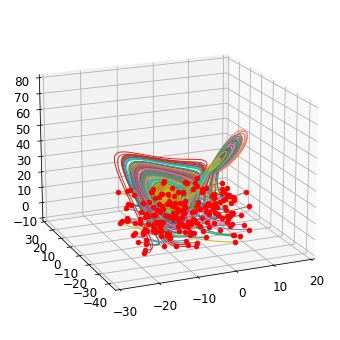

In [6]:
## Simulate the Lorenz System
rho = 17

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

np.random.seed(test_seed)
x0 = -15 + 30 * np.random.random((n_ic, 3))

x_t_plot =  np.asarray([integrate.odeint(lambda x,t : lorenz_deriv(x, t, rho = rho), x0_j, t)
                  for x0_j in x0])

for j in range(n_ic):
    x, y, z = x_t_plot[j,:,:3].T
    ax.plot(x, y, z,linewidth=1)
    ax.set_xlim((-30,20))
    ax.set_ylim((-45,30))
    ax.set_zlim((-10,80))
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

## Approach I: Advance solution from $t$ to $t + \Delta t$

In [7]:
num_traj = 3

x_t = np.array([integrate.odeint(lambda x, t: lorenz_deriv(x, t, rho =  rho) , x0[i, :], t) for i in range(num_traj)])

x_t_input = np.concatenate((x_t.reshape(num_traj*len(t),3), np.ones(shape = (num_traj*len(t),1))*rho), axis = 1)
pred = nn_model.predict(x_t_input).reshape(num_traj, len(t), 3)
pred = np.concatenate((x_t[:,0:1,:], pred), axis = 1)

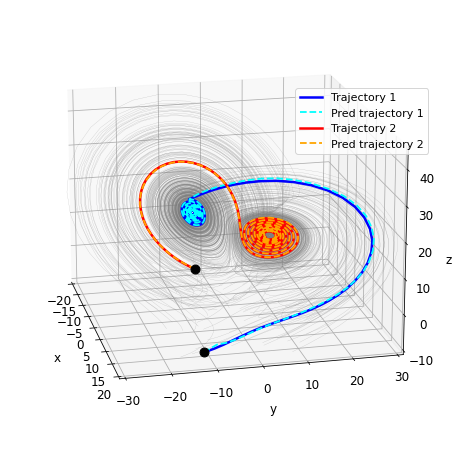

In [8]:
x_t = np.array([integrate.odeint(lambda x, t: lorenz_deriv(x, t, rho =  rho) , pred[i, 0, :3], t) for i in range(num_traj)])

fig = plt.figure(figsize = [12,8])
ax = fig.add_subplot(111, projection='3d')

for j in range(n_ic):
    x, y, z = x_t_plot[j,:,:3].T
    ax.plot(x, y, z,linewidth=0.2, color = 'gray', alpha = 0.6)

colors = ['blue', 'red'] 
colors_ = ['cyan', 'orange'] 
for j in range(num_traj):
    x, y, z = x_t[j, :, :].T
    xd, yd, zd = pred[j, :, :3].T
    ax.plot(x, y, z, color = colors[j], linewidth=2.5, label = 'Trajectory ' + str(j+1))
    ax.plot(xd, yd, zd, '--', color = colors_[j], lw=1.8, label = 'Pred trajectory ' + str(j+1))
    ax.set_xlabel('x', labelpad = 10)
    ax.set_ylabel('y', labelpad = 10)
    ax.set_zlabel('z', labelpad = 5)
    ax.set_xlim((-20,20))
    ax.set_ylim((-30,30))
    ax.set_zlim((-10,45))
    ax.scatter(x[0], y[0], z[0], color= 'black', s= 80)
             
ax.view_init(18, -13)
#plt.title('NN output – rho = 17, approach (I)')
plt.legend(fontsize = 11, bbox_to_anchor = [0.65,0.65] )
#plt.savefig('Lorenz_17.pdf', dpi=300, transparent=True, bbox_inches='tight', pad_inches = 0)
plt.show()

## Approach II (recursive): Advance solution from $t$ to $t + \Delta t$

In [9]:
np.random.seed(test_seed)

nn_flow = np.zeros((num_traj, len(t), 4))
nn_flow[:, 0, :3] = -15 + 30 * np.random.random((num_traj, 3))
nn_flow[:, :, -1] = np.ones((num_traj, len(t))) * rho

for jj, tval in enumerate(t[:-1]):
    nn_flow[:, jj+1, :3] = nn_model.predict(nn_flow[:, jj, :])

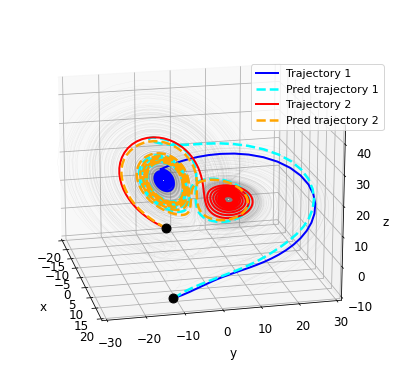

In [10]:
fig = plt.figure(figsize = [12,6.75])
ax = fig.add_subplot(111, projection='3d')

for j in range(n_ic):
    x, y, z = x_t_plot[j,:,:3].T
    ax.plot(x, y, z,linewidth=0.25, color = 'gray', alpha = 0.15)

colors = ['blue', 'red'] 
colors_ = ['cyan', 'orange'] 
for j in range(num_traj):
    x, y, z = x_t[j, :, :].T
    xd, yd, zd = nn_flow[j, :, :3].T
    ax.plot(x, y, z, color = colors[j], linewidth=2, label = 'Trajectory ' + str(j+1))
    ax.plot(xd, yd, zd, '--', color = colors_[j], lw=2.5, label = 'Pred trajectory ' + str(j+1))
    ax.set_xlabel('x', labelpad = 10)
    ax.set_ylabel('y', labelpad = 10)
    ax.set_zlabel('z', labelpad = 5)
    ax.set_xlim((-20,20))
    ax.set_ylim((-30,30))
    ax.set_zlim((-10,45))
    ax.scatter(x[0], y[0], z[0], color= 'black', s= 80)
             
ax.view_init(18, -13)
plt.legend(fontsize = 11, bbox_to_anchor = [0.65,0.65] )
#plt.savefig('Lorenz_17_seq.pdf', dpi=300, transparent=True, bbox_inches='tight', pad_inches = 0)
plt.show()

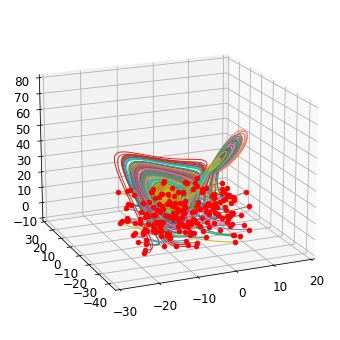

In [11]:
## Simulate the Lorenz System
rho = 17

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

np.random.seed(test_seed)
x0 = -15 + 30 * np.random.random((n_ic, 3))

x_t_plot =  np.asarray([integrate.odeint(lambda x,t : lorenz_deriv(x, t, rho = rho), x0_j, t)
                  for x0_j in x0])

for j in range(n_ic):
    x, y, z = x_t_plot[j,:,:3].T
    ax.plot(x, y, z,linewidth=1)
    ax.set_xlim((-30,20))
    ax.set_ylim((-45,30))
    ax.set_zlim((-10,80))
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

## Test $\rho = 40$
Test the NN model for a new value $\rho = 40$

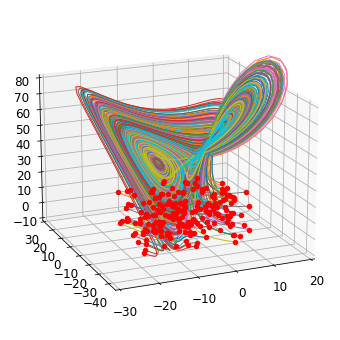

In [12]:
## Simulate the Lorenz System
rho = 40

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

np.random.seed(test_seed)
x0 = -15 + 30 * np.random.random((n_ic, 3))

x_t_plot =  np.asarray([integrate.odeint(lambda x,t : lorenz_deriv(x, t, rho = rho), x0_j, t)
                  for x0_j in x0])

for j in range(n_ic):
    x, y, z = x_t_plot[j,:,:3].T
    ax.plot(x, y, z,linewidth=1)
    ax.set_xlim((-30,20))
    ax.set_ylim((-45,30))
    ax.set_zlim((-10,80))
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

## Approach I: Advance solution from $t$ to $t + \Delta t$

In [13]:
num_traj = 3

x_t = np.array([integrate.odeint(lambda x, t: lorenz_deriv(x, t, rho =  rho) , x0[i, :], t) for i in range(num_traj)])

x_t_input = np.concatenate((x_t.reshape(num_traj*len(t),3), np.ones(shape = (num_traj*len(t),1))*rho), axis = 1)
pred = nn_model.predict(x_t_input).reshape(num_traj, len(t), 3)
pred = np.concatenate((x_t[:,0:1,:], pred), axis = 1)

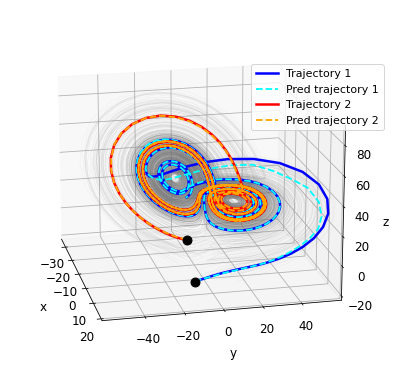

In [14]:
x_t = np.array([integrate.odeint(lambda x, t: lorenz_deriv(x, t, rho =  rho) ,  nn_flow[i, 0, :3], t) for i in range(num_traj)])

fig = plt.figure(figsize = [12,6.75])
ax = fig.add_subplot(111, projection='3d')

for j in range(n_ic):
    x, y, z = x_t_plot[j,:,:3].T
    ax.plot(x, y, z,linewidth=0.25, color = 'gray', alpha = 0.15)

colors = ['blue', 'red']  
colors_ = ['cyan', 'orange']  
for j in range(num_traj):
    x, y, z = x_t[j, :, :].T
    xd, yd, zd = pred[j, :, :3].T
    ax.plot(x, y, z, color = colors[j], linewidth=2.5, label = 'Trajectory ' + str(j+1))
    ax.plot(xd, yd, zd, '--', color = colors_[j], lw=1.8, label = 'Pred trajectory ' + str(j+1))
    ax.set_xlabel('x', labelpad = 10)
    ax.set_ylabel('y', labelpad = 10)
    ax.set_zlabel('z', labelpad = 5)
    ax.set_xlim((-35,20))
    #ax.set_ylim((-30,30))
    #ax.set_zlim((-10,45))
    ax.scatter(x[0], y[0], z[0], color= 'black', s= 80)
             
ax.view_init(18, -13)
plt.legend(fontsize = 11, bbox_to_anchor = [0.65,0.65] )
#plt.savefig('Lorenz_40.pdf', dpi=300, transparent=True, bbox_inches='tight', pad_inches = 0)
plt.show()

## Approach II (recursive): Advance solution from $t$ to $t + \Delta t$

In [15]:
np.random.seed(test_seed)

nn_flow = np.zeros((num_traj, len(t), 4))
nn_flow[:, 0, :3] = -15 + 30 * np.random.random((num_traj, 3))
nn_flow[:, :, -1] = np.ones((num_traj, len(t))) * rho

for jj, tval in enumerate(t[:-1]):
    nn_flow[:, jj+1, :3] = nn_model.predict(nn_flow[:, jj, :])

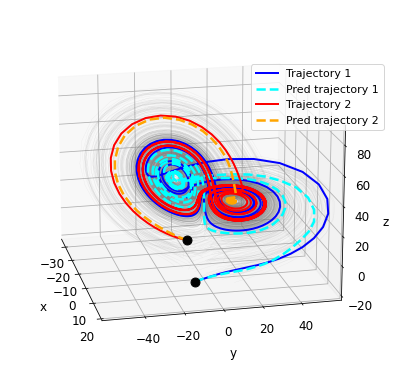

In [16]:
fig = plt.figure(figsize = [12,6.75])
ax = fig.add_subplot(111, projection='3d')

for j in range(n_ic):
    x, y, z = x_t_plot[j,:,:3].T
    ax.plot(x, y, z,linewidth=0.25, color = 'gray', alpha = 0.15)

colors = ['blue', 'red']
colors_ = ['cyan', 'orange'] 
for j in range(num_traj):
    x, y, z = x_t[j, :, :].T
    xd, yd, zd = nn_flow[j, :, :3].T
    ax.plot(x, y, z, color = colors[j], linewidth=2, label = 'Trajectory ' + str(j+1))
    ax.plot(xd, yd, zd, '--', color = colors_[j], lw=2.5, label = 'Pred trajectory ' + str(j+1))
    ax.set_xlabel('x', labelpad = 10)
    ax.set_ylabel('y', labelpad = 10)
    ax.set_zlabel('z', labelpad = 5)
    ax.set_xlim((-35,20))
    #ax.set_ylim((-30,30))
    #ax.set_zlim((-10,45))
    ax.scatter(x[0], y[0], z[0], color= 'black', s= 80)
             
ax.view_init(18, -13)
plt.legend(fontsize = 11, bbox_to_anchor = [0.65,0.65] )
#plt.savefig('Lorenz_40_seq.pdf', dpi=300, transparent=True, bbox_inches='tight', pad_inches = 0)
plt.show()